# Separation of Rhythms

Recordings of neural activity can pick up multiple, overlapping, oscillations.

### Issue

Neural recordings may often reflect mixtures of multiple underlying sources. 

Measures applied these combined signals may not accurately reflect the underlying signal components.

### Solution

Source separation techniques can be used to separate sources, which can then be analyzed individually. 

### Related Work

- [A novel method for reliable and fast extraction of neuronal EEG/MEG oscillations on the basis of spatio-spectral decomposition](https://doi.org/10.1016/j.neuroimage.2011.01.057), Nikulin et al, 2011


### Additional Requirements

This example has some additional required components:

- The demo leadfield plot, requires the 'NYhead' leadfield model from:
https://www.parralab.org/nyhead/sa_nyhead.mat

    - Documentation for this is available here: https://www.parralab.org/nyhead/

- In addition, this example uses additional requirements: `h5py`, `mne`, `pyvista`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from fooof.plts.spectra import plot_spectrum_shading
from fooof.utils import trim_spectrum

from neurodsp.sim import sim_oscillation, sim_powerlaw, sim_combined
from neurodsp.filt import filter_signal
from neurodsp.spectral import compute_spectrum
from neurodsp.timefrequency import amp_by_time, phase_by_time, freq_by_time
from neurodsp.utils import create_times, set_random_seed
from neurodsp.plts.time_series import plot_time_series, plot_instantaneous_measure

In [2]:
# Import additional requirements needed for this example
import mne
from mne.time_frequency import psd_welch
import pyvista as pv
from h5py import File

In [3]:
# Add path and import custom code for the project
import sys
sys.path.append('code')
from spatial import *
from utils import mu_wave
from plts import plot_data_grid, savefig
from settings import ALPHA_COLOR, ALPHA_RANGE

## Settings

In [4]:
import seaborn as sns
sns.set_context('poster')

In [5]:
# Set random seed
set_random_seed(808)

In [6]:
# Define general simulation settings
n_seconds = 30
fs = 1000

times = create_times(n_seconds, fs)

In [7]:
# Define parameters for the simulations
cf1 = 9.5
ph1 = 0

cf2 = 10.5
ph2 = 0.25

exp = -2
ap_filt = (2, 150)

In [8]:
# Collect parameters and set up simulations
components = {'sim_powerlaw' : {'f_range' : ap_filt},
              'sim_oscillation' : [{'freq' : cf1, 'phase' : ph1},
                                   {'freq' : cf2, 'phase' : ph2}]}


# Define parameters for signals with only of the alphas, for comparison
comps_a1 = {'sim_powerlaw' : {'f_range' : ap_filt},
            'sim_oscillation' : {'freq' : cf1, 'phase' : ph1}}
comps_a2 = {'sim_powerlaw' : {'f_range' : ap_filt},
            'sim_oscillation' : {'freq' : cf2, 'phase' : ph2}}

# Define relative power of the signal components
comp_vars = [1, 0.5, 0.5]

In [9]:
# Define frequency ranges of interest
psd_range = [3, 35]

In [10]:
# Plot settings
colors = ("#CC2B1C", "#3C2C71", "#115C12")

In [11]:
# Set whether to save out figures
SAVE_FIG = False

## Simulate time series with multiple components (sources)

For this example, we will simulate a signal that includes multiple putative sources, by adding multiple components to the signal. 

In [12]:
# Simulate each component for the complete signal separately
comp_ap = sim_powerlaw(n_seconds, fs, exponent=exp, f_range=ap_filt)
comp_pe1 = sim_oscillation(n_seconds, fs, cf1, phase=ph1, variance=0.75)
comp_pe2 = sim_oscillation(n_seconds, fs, cf2, phase=ph2, variance=0.75)

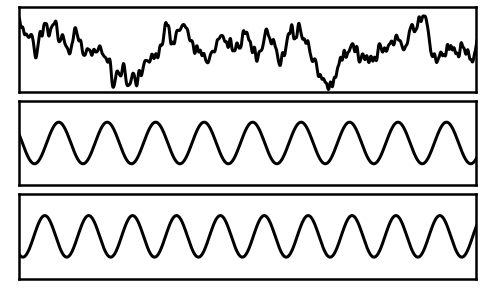

In [13]:
# Plot each component of the complete signal separately
plt_kwargs = {'xlim' : [1, 2], 'ylim' : [-2.5, 2.5], 'lw' : 3, 
              'xlabel' : '', 'ylabel' : ''}
_, axes = plt.subplots(3, 1, figsize=(8, 5))
plot_time_series(times, comp_ap, ax=axes[0], **plt_kwargs)
plot_time_series(times, comp_pe1, ax=axes[1], **plt_kwargs)
plot_time_series(times, comp_pe2, ax=axes[2], **plt_kwargs)
for ax in axes: ax.set_xticks([]); ax.set_yticks([]);
plt.subplots_adjust(hspace=0.1)
plt.savefig('figures/06-ts-sigcomps.pdf', bbox_inches='tight')

In [14]:
# Simulate the combined signal, with all components
sig = sim_combined(n_seconds, fs, components, comp_vars)

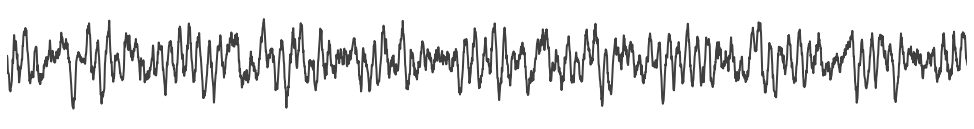

In [15]:
# Plot the combined signal
plot_time_series(times, sig, lw=2, xlim=[10, 20], alpha=0.75)
plt.axis('off')
savefig(SAVE_FIG, '06-ts_comb')

Next we will compute instantaneous measures of the combined signal. 

Note that, in the combined signal, each of the oscillatory components is totally consistent (has no variation across time). 

Any observed variation seen in the instantaneous measures therefore must be arising due the overlap / interference of multiple signals. 

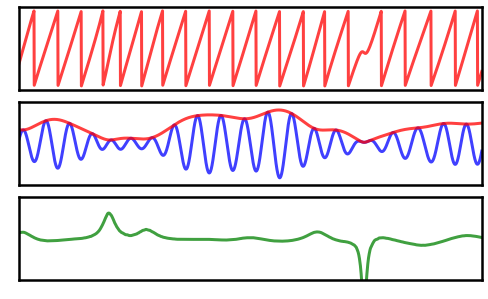

In [16]:
# Plot the instantaneous measures of the combined signal
plt_kwargs= {'xlim' : [14, 16], 'alpha' : 0.75, 'xlabel' : '', 'ylabel' : ''}
_, axes = plt.subplots(3, 1, figsize=(8, 5))
plot_instantaneous_measure(times, phase_by_time(sig, fs, ALPHA_RANGE),
                           'phase', ax=axes[0], colors='r', **plt_kwargs)
plot_instantaneous_measure(times, [filter_signal(sig, fs, 'bandpass', ALPHA_RANGE),
                                                 amp_by_time(sig, fs, ALPHA_RANGE)],
                           'amplitude', ax=axes[1], colors=['b', 'r'], **plt_kwargs)
plot_instantaneous_measure(times, freq_by_time(sig, fs, ALPHA_RANGE),
                           'frequency', ax=axes[2], colors='g', ylim=[2.5, 17.5], **plt_kwargs)
for ax in axes: ax.set_xticks([]); ax.set_yticks([]);
plt.subplots_adjust(hspace=0.15)
savefig(SAVE_FIG, '06-ts-measures')

Lastly, we will plot the power spectrum.

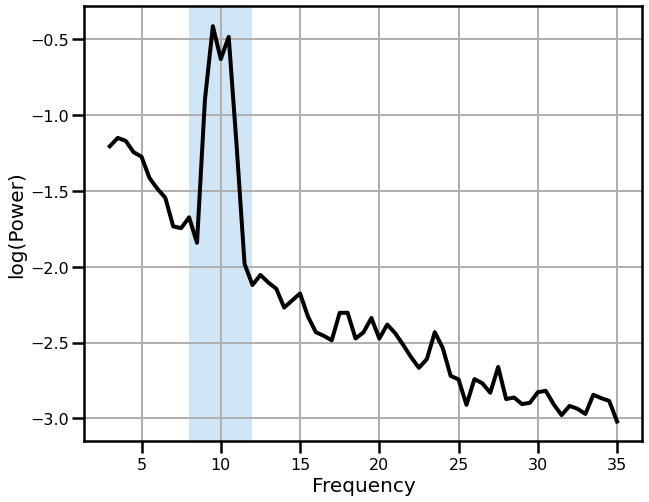

In [17]:
# Plot the power spectrum of the combined signal
freqs, powers = trim_spectrum(*compute_spectrum(sig, fs, nperseg=2*fs), psd_range)
plot_spectrum_shading(freqs, powers, ALPHA_RANGE,
                      log_freqs=False, log_powers=True,
                      lw=4,  color='k', shade_colors=ALPHA_COLOR)
savefig(SAVE_FIG, '06-psd')

Note that the power spectrum has a suggestion of a double peak, though it is not clear just from this if this reflects multiple oscillations.

Collectively, in the above, we can see how having multiple, continuous, oscillations, that contribute to the same recorded signal, can lead to interference of the sources, and variable measures that may be difficult to interpret.

## Source Separation

In the above, we just simulated signals and added them together. 

In actual data, the combination of underlying sources happens in particular ways, as different cortical sources are 'seen' by overlying electrodes. 

For the next examples, we will use a head model to simulate this more directly. 

In the following, we will be refer to the 'leadfield', which is a mathematical description of how underlying sources are reflected in overlying electrodes. 

In [18]:
# Load lead field matrix & get data of interest
h5_file = File("data/sa_nyhead.mat", "r")
ch_names, electrodes, leadfield = load_helper(h5_file)

# Select an electrode of interest for plotting
selected_channel = "PO3h"
ch1 = "PPO5"
ch2 = "O1"

In [19]:
# Get the needed leadfield coefficients from the file
leadfield_coef, idx_source1, idx_source2 = \
    get_leadfield_coefs(h5_file, ch1, ch2, selected_channel)

In [20]:
# General settings for next set of simulations
n_signals = 3
n_samples = 10000
n_seconds = n_samples / fs
times = np.linspace(0, n_seconds, n_samples)

# Settings for examples
main_freq1 = 11
main_freq2 = 9
main_freq3 = 10
ap_level = 1.75
exponent = -2

In [21]:
# Aperiodic components for examples
ap1 = ap_level * sim_powerlaw(n_seconds, fs, exponent=exponent)
ap2 = ap_level * sim_powerlaw(n_seconds, fs, exponent=exponent)

### Plot Brain

For the following examples, we be using a head model, with two cortical sources (red and blue), recorded by an overlying electrode (green). 

First, we will plot the head and cortex model, showing the sources and the electrode of interest. 

In [22]:
# Create the head plot
plot_head(h5_file, ch1, ch2, selected_channel, False)

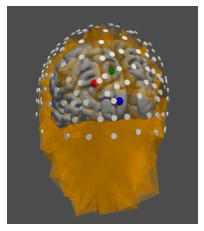

In [23]:
# Display the 3d head image
_, ax_head = plt.subplots()
ax_head.imshow(mpimg.imread("mesh_nyhead.png"))
ax_head.set(xlim=(180, 1100), ylim=(1200, 150))
ax_head.axis("off");

## Example 1: Different Peak Frequencies

In the next example, we will simulate two source signals (red and blue) with slightly different frequencies.

Note that the simulated example here is a 'mu' wave - an asymetric wave in the alpha range (see notebook 05).

Due to the frequency differences, these oscillations will lead to a combined signal at the recorded electrode (green). 

In [24]:
# Create simulated data and organize into an MNE object
epochs = np.zeros((n_signals, n_samples))
epochs[0] = mu_wave(times, main_freq=main_freq1, wave_shift=1) + ap1
epochs[1] = mu_wave(times, main_freq=main_freq2, wave_shift=1) + ap2
epochs[2] = leadfield_coef[0, 0] * epochs[0] + leadfield_coef[0, 1] * epochs[1]
raw = make_mne(epochs, fs)

In [25]:
# Compute spectra
psd, freq = psd_welch(raw, fmin=1, fmax=35, n_fft=2001, n_overlap=500)

Effective window size : 2.001 (s)


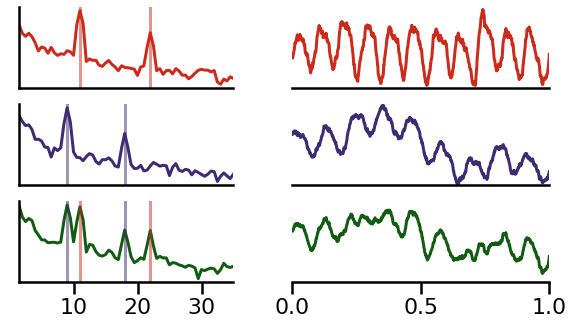

In [26]:
# Plot power spectra and time series for the 1st example
raw.crop(0, 1);
plot_data_grid(raw.times, raw._data, freq, psd, colors, main_freq1, main_freq2)
savefig(SAVE_FIG, '06-example1_grid')

In the above, we can see how the source signal time series has variable across time cancellation due to the interference between the similar frequencies. 

## Example 2: Different Phases

In the next example, we will simulate two source signals (red and blue) at the same frequency, but with a phase offset between them. 

Note that the simulated example here is a 'mu' wave - an asymetric wave in the alpha range (see notebook 05).

Due to the phase shift, these oscillations will experience destructive experience at the recorded electrode (green). 

In [27]:
# Create simulated data and organize into an MNE object
epochs = np.zeros((n_signals, n_samples))
epochs[0] = mu_wave(times, main_freq=main_freq3, shift=0) + ap1
epochs[1] = mu_wave(times, main_freq=main_freq3, shift=np.pi) + ap2
epochs[2] = leadfield_coef[0, 0] * epochs[0] + leadfield_coef[0, 1] * epochs[1]
raw2 = make_mne(epochs, fs)

In [28]:
# Compute power spectra for the signals
psd2, freq = psd_welch(raw2, fmin=1, fmax=35, n_fft=2001, n_overlap=500)

Effective window size : 2.001 (s)


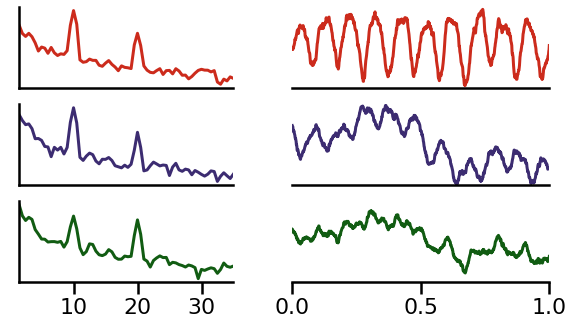

In [29]:
# Plot power spectra and time series for the 2nd example
raw2.crop(0, 1);
plot_data_grid(raw.times, raw2._data, freq, psd2, colors)
savefig(SAVE_FIG, '06-example2_grid')

In the above example, we can see how the source signal experiences a lot of cancellation in the times series recorded at the electrode.

### Sources

Here we will plot the sources for the examples above.

In [30]:
# Create an MNE object for plotting topographies
raw3 = make_mne_topo(ch_names, electrodes, fs, leadfield, idx_source1, idx_source2)

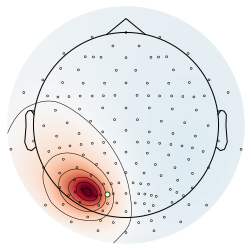

In [31]:
# Plot leadfield for source 1
plot_topography(raw3, 0, selected_channel, colors)
savefig(SAVE_FIG, '06-source1_topo')

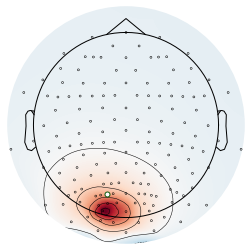

In [32]:
# Plot leadfield for source 2
plot_topography(raw3, 1, selected_channel, colors)
savefig(SAVE_FIG, '06-source2_topo')

## Conclusion

What is recorded at the electrodes level may reflect multiple sources. 

As we've seen in this example, the combined signal can look much more variable than the underlying components it reflects. 

This stems from how oscillatory signals sum together - and the ways in which they partially cancel each other out.

Measures computed on the recorded signal may not directly reflect the underlying signals, but rather the interference between multiple sources.

To address this, source separation approaches can be used to try to separate different underlying sources, which can then be analyzed separately. 